In [ ]:
'''
【项目10】  房价影响因素挖掘

作业要求
1、数据清洗、整合
要求：
① 将“house_rent”、“house_sell”分别读取
② 分别计算平方米建筑面积的月租金、每平方米建筑面积的房价
③ 将数据按照小区名合并
提示：
① 删除缺失值
② 按照小区做均值分析

2、计算“房屋售租比”，并做初步判断
要求：
① 计算指标
② 绘制直方图、箱型图看“售租比”的一个数据分布情况
提示：
① “房屋售租比”=“每平方米建筑面积的房价”/“每平方米建筑面积的月租金” 
② 直方图bins数量大于80来作图

3、上海市人口密度、路网密度、餐饮价格和“房屋每平米均价”是否有关系呢？
要求：
① 首先，导出整理好的数据，并qgis中绘制空间格网图，查看房屋每平米均价、房屋每平米租金及售租比数据的空间分布
② 第二，空间统计，分别按照格网对人口密度、路网密度、餐饮价格进行指标统计并标准化
③ 第三，加载上海中心点point空间数据，计算每个网格到市中心距离
④ 第四，将空间格网的“房屋每平米均价”按照距市中心的距离排序，并制作散点图，看看能否挖掘出什么信息
   *** 这里市中心点坐标为：lng-353508.848122，lat-3456140.926976 (投影坐标系)
提示：
① 导出csv数据，用dataframe.to_csv()
② qgis加载数据后，以“net_population”为格网数据做空间统计
③ 注意qgis数据都为投影坐标系
④ 人口密度指标 → 已有“net_population”数据
   路网密度指标 → 以格网为空间单元，计算道路长度
   餐饮价格指标 → 以格网为空间单元，计算餐饮设施的人均均价数据
   *** 最后数据导入python中，标准化得分至0-1区间
   *** 导入数据后要填充空值为0
   *** qgis中可以用结果net数据作为下一个分析数据，以此将统计结果汇总在一张属性表内
   *** 格网数据在导出前，先转为点数据，并计算经纬度，这里用投影经纬度，好依据中心点坐标计算离市中心距离
⑤ 清洗数据，去除“售租比”为0的数据

4、按照离市中心距离每10km，分别再次判断人口密度、路网密度、餐饮价格和“房屋每平米均价”的相关程度
要求：
① 按照空间距离分别迭代计算三指标和“房屋每平米均价”的关系
② 绘制折线图查看：随着市中心距离增加，不同指标相关系系数变化情况
   *** 建议用bokeh制图
提示：
① 用for循环迭代空间距离，然后筛选数据并计算相关性
② bokeh可以通过多次调用figure.line()来绘制多条折线图

'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [ ]:
'''
1、数据清洗、整合
要求：
① 将“house_rent”、“house_sell”分别读取
② 分别计算平方米建筑面积的月租金、每平方米建筑面积的房价
③ 将数据按照小区名合并
提示：
① 删除缺失值
② 按照小区做均值分析

'''

In [2]:
# 查看数据,数据清洗

import os
os.chdir(r'C:\Users\Administrator\Python数据\网易数据分析\1项目资料\项目10房价影响因素挖掘')
# 创建工作路径

df01 = pd.read_csv('house_rent.csv',engine = 'python')
df02 = pd.read_csv('house_sell.csv',engine = 'python')
# 读取数据

df01.dropna(inplace = True)
df02.dropna(inplace = True)

# 删除缺失值

In [3]:
df01.head(4)
# 查看租房数据

,title,community,address,city,district,price,area,lng,lat
0,曹江公寓，钥匙房，真实在租，精致户型,曹江公寓,临夏路98弄,上海,嘉定,3400,79.0,121.343132,31.264662
1,中星海兰苑，两室户，高清照片，如您所见,中星海兰苑,华江支路677弄,上海,嘉定,4000,80.0,121.344133,31.271693
2,嘉旺苑，南北通透，好房待租，空气清新,嘉旺苑,靖远路1288弄,上海,嘉定,4900,95.0,121.332318,31.262940
3,汇丰沁苑，小户型，高区景观房，一链倾城,汇丰沁苑,临夏路800弄;临夏路801弄,上海,嘉定,3100,53.0,121.335524,31.261589


In [4]:
df02.head(4)
# 查看售房数据

,title,property_name,address,city,district,total_price,area,average_price,lat,lng
0,鑫苑国际城市花园，真实在售，视野很好，上门实勘,鑫苑国际城市花园,绿地大道189号,上海,上海周边,160.0,88.00,18181.0,31.286296,121.143489
1,南北直通，高区景观房，拎包入住，房本满五年,花苑新村（昆山）上海周边昆山,花桥镇花苑新村,上海,上海周边,210.0,169.83,12365.0,31.308387,121.082040
2,正规成熟小区，一链倾城，装修精致，3室2厅,绿地卡米小城,外青松公路988号,上海,上海周边,180.0,87.75,20512.0,31.311252,121.148217
3,厨卫全明，客厅朝南，低区出入方便，装修精美,绿地卡米小城上海周边昆山,外青松公路988号,上海,上海周边,180.0,90.00,20000.0,31.311252,121.148217


In [5]:
# 计算指标并按照租金、售价汇总
# ① 每平方米建筑面积的月租金
# ② 每平方米建筑面积的房价
# ③ 按照小区做均值分析

df01['rent_area'] = df01['price']/df01['area'] # ① 每平方米建筑面积的月租金
data_rent = df01[['community','rent_area','lng','lat']].groupby(by = 'community').mean() # ③ 按照小区做均值分析
data_sell = df02[['property_name','average_price','lng','lat']].groupby(by = 'property_name').mean() # 'average_price'② 每平方米建筑面积的房价
data_rent.reset_index(inplace = True)
data_sell.reset_index(inplace = True)

In [6]:
print('租房数据量为%i条' % len(data_rent))
data_rent.head(4)
# 查看汇总后的租金

租房数据量为15309条


,community,rent_area,lng,lat
0,GOHO悦城,42.857143,121.129861,31.299975
1,MAX未来,73.223568,121.342043,31.275791
2,VIP大厦,91.950017,121.532216,31.246939
3,YOHO街区,61.636618,121.342542,31.273815


In [7]:
print('售房数据量为%i条' % len(data_sell))
data_sell.head(4)
# 查看汇总后的售价

售房数据量为25657条


,property_name,average_price,lng,lat
0,BPC陆家嘴创业街区浦东洋泾,100000.0,121.568202,31.243279
1,VIP大厦,75933.0,121.532216,31.246939
2,VIP大厦浦东源深,80400.0,121.532216,31.246939
3,一品名人居,82699.0,121.453460,31.241146


In [8]:
# 数据合并

data = pd.merge(data_rent,data_sell,left_on ='community',right_on='property_name')
print(data.head(3)) # merge()后的数据，列名相同的会默认加上'_x','_y'
data = data[['community','rent_area','average_price','lng_x','lat_x']]
data.rename(columns={'average_price':'sell_area', 'lng_x':'lng', 'lat_x':'lat'}, inplace = True)  # 调整列名
print('合并后数据量为%i条' % len(data))
data.head(10)

  community   rent_area       lng_x      lat_x property_name  average_price  \
0     VIP大厦   91.950017  121.532216  31.246939         VIP大厦   75933.000000   
1     一品名人居  110.929607  121.453460  31.241146         一品名人居   82699.000000   
2     一品新筑苑   74.719974  121.477821  31.308435         一品新筑苑   73413.818182   

        lng_y      lat_y  
0  121.532216  31.246939  
1  121.453460  31.241146  
2  121.477821  31.308435  
合并后数据量为11532条


,community,rent_area,sell_area,lng,lat
0,VIP大厦,91.950017,75933.000000,121.532216,31.246939
1,一品名人居,110.929607,82699.000000,121.453460,31.241146
2,一品新筑苑,74.719974,73413.818182,121.477821,31.308435
3,一品漫城(一期)(公寓),119.869790,59565.137931,121.501431,31.123422
4,一品漫城(一期)(别墅),70.518859,62391.666667,121.500957,31.122432
5,一品漫城(三期),125.974786,59123.500000,121.497674,31.121585
6,一品漫城(二期),93.868746,62263.866667,121.500957,31.122078
7,一品漫城(五期),95.919983,63258.000000,121.498043,31.120196
8,一品漫城(四期)(公寓),91.170830,61815.416667,121.494715,31.119846
9,一品漫城四期,54.274084,75033.000000,121.498073,31.119761


In [ ]:
'''
2、计算“房屋售租比”，并做初步判断
要求：
① 计算指标
② 绘制直方图、箱型图看“售租比”的一个数据分布情况
提示：
① “房屋售租比”=“每平方米建筑面积的房价”/“每平方米建筑面积的月租金” 
② 直方图bins数量大于80来作图

'''

In [9]:
# 计算“房屋售租比”，并做初步判断
# “房屋售租比”=“每平方米建筑面积的房价”/“每平方米建筑面积的月租金” 
# 含义可以简单理解为：“在保持当前的房价和租金条件不变的情况下，完全收回投资需要多少个月？”
#  **一般而言，按照国际经验，在一个房产运行情况良好的区域，应该可以在200-300个月内完全回收投资。
#  **如果少于200个月（17年）就能收回投资，说明这个地区有较高的投资价值；
#  **如果一个地区需要高于300个月（25年），比如1200个月（100年）才能回收投资，则说明该地区有潜在的房产泡沫风险。

data['sell_rent'] = data['sell_area']/data['rent_area']
print('上海房屋租售比中位数为%i个月' % data['sell_rent'].median())
# 计算售租比，及中位数

上海房屋租售比中位数为725个月


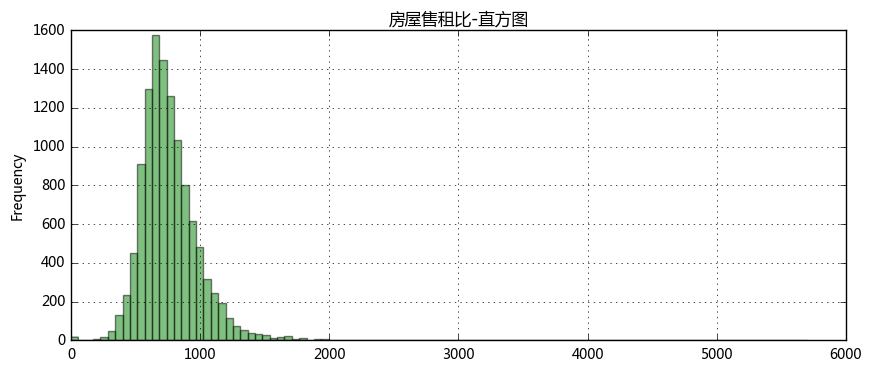

In [10]:
# 绘制直方图
data['sell_rent'].plot.hist(stacked=True,bins=100,color = 'green',alpha=0.5,grid=True,figsize = (10,4))
plt.title('房屋售租比-直方图')

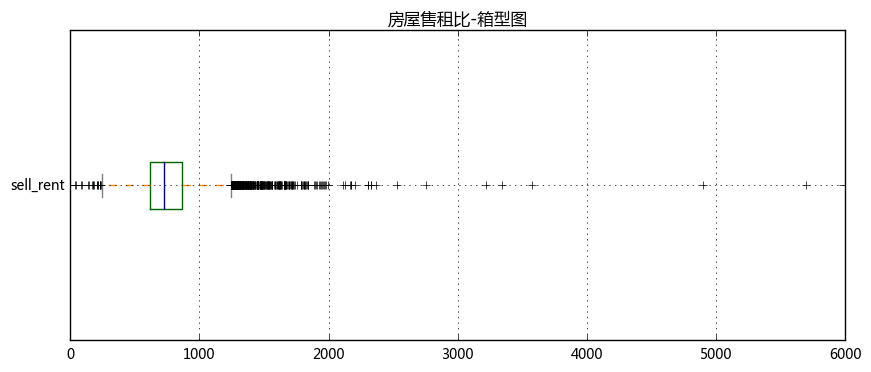

In [11]:
# 绘制箱型图
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
data['sell_rent'].plot.box(vert=False, grid = True,color = color,figsize = (10,4)) 
plt.title('房屋售租比-箱型图')

In [ ]:
# 一个尴尬的结论
# 如果按照中位数725个月来看，假设从25岁研究生一毕业，就立刻全款买了一套房，然后放出去收租
# 那么约85岁时，这60年来陆陆续续所收的租金总数就可以达到了25岁时买房所付的钱啦
# **这里还没考虑净现值折算问题
# ① 如果仅靠租金收入的话，上海全市平均回收投资需要725个月。而这种格局的维持，必须有赖于购房者对上海的房价上升的持续预期。
#    也就是说，在上海，投资房产绝不是利率收益，而是预期收益（其实城市越小租金回报反而越高）
# ② 上海不是这么看住房投资的（绝大多数房子房租收入跑不赢商贷利率，否则按照这个思路看那肯定是买一个亏一个）

In [ ]:
'''
3、上海市人口密度、路网密度、餐饮价格和“房屋每平米均价”是否有关系呢？
要求：
① 首先，导出整理好的数据，并qgis中绘制空间格网图，查看房屋每平米均价、房屋每平米租金及售租比数据的空间分布
② 第二，空间统计，分别按照格网对人口密度、路网密度、餐饮价格进行指标统计并标准化
③ 第三，加载上海中心点point空间数据，计算每个网格到市中心距离
④ 第四，将空间格网的“房屋每平米均价”按照距市中心的距离排序，并制作散点图，看看能否挖掘出什么信息
   *** 这里市中心点坐标为：lng-353508.848122，lat-3456140.926976 (投影坐标系)
提示：
① 导出csv数据，用dataframe.to_csv()
② qgis加载数据后，以“net_population”为格网数据做空间统计
③ 注意qgis数据都为投影坐标系
④ 人口密度指标 → 已有“net_population”数据
   路网密度指标 → 以格网为空间单元，计算道路长度
   餐饮价格指标 → 以格网为空间单元，计算餐饮设施的人均均价数据
   *** 最后数据导入python中，标准化得分至0-1区间
   *** 导入数据后要填充空值为0
   *** qgis中可以用结果net数据作为下一个分析数据，以此将统计结果汇总在一张属性表内
   *** 格网数据在导出前，先转为点数据，并计算经纬度，这里用投影经纬度，好依据中心点坐标计算离市中心距离
⑤ 清洗数据，去除“售租比”为0的数据

'''

In [12]:
# 导出数据
data.to_csv('pro10data.csv')
print('finished!')

finished!


In [13]:
# 加载数据

data_q3 = pd.read_csv('C:/Users/Hjx/Desktop/result02.csv',engine = 'python')
data_q3.fillna(0,inplace = True)
data_q3.head(10)

,Z,point_coun,rent_area_,sell_area_,sell_rent_,roadlength,cy_count,人均消费_,lng,lat
0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,334590.174,3396010.739
1,0,0.0,0.0,0.0,0.0,128.477758,0.0,0.0,333590.174,3397010.739
2,0,0.0,0.0,0.0,0.0,1539.908057,0.0,0.0,334590.174,3397010.739
3,0,0.0,0.0,0.0,0.0,1032.299541,0.0,0.0,335590.174,3397010.739
4,0,0.0,0.0,0.0,0.0,1543.891782,0.0,0.0,336590.174,3397010.739
5,0,0.0,0.0,0.0,0.0,172.251963,0.0,0.0,337590.174,3397010.739
6,0,0.0,0.0,0.0,0.0,2038.437108,0.0,0.0,338590.174,3397010.739
7,0,0.0,0.0,0.0,0.0,2011.393625,0.0,0.0,339590.174,3397010.739
8,0,0.0,0.0,0.0,0.0,123.736459,0.0,0.0,340590.174,3397010.739
9,0,0.0,0.0,0.0,0.0,1001.947338,0.0,0.0,333590.174,3398010.739


In [14]:
# 指标标准化

def f1(data,col):
    return (data[col]-data[col].min())/(data[col].max()-data[col].min())
# 创建函数

data_q3['人口密度指标'] = f1(data_q3,'Z')
data_q3['路网密度指标'] = f1(data_q3,'roadlength')
data_q3['餐饮价格指标'] = f1(data_q3,'人均消费_')
# 指标标准化

data_q3['离市中心距离'] = ((data_q3['lng'] - 353508.848122)**2 + (data_q3['lat']-3456140.926976)**2)**0.5
# 计算市中心距离

data_q3_test = data_q3[['人口密度指标','路网密度指标','餐饮价格指标','sell_area_','离市中心距离']]
data_q3_test = data_q3_test[data_q3_test['sell_area_']>0].reset_index()
del data_q3_test['index']
data_q3_test.head(10)
# 清洗数据，去除“房屋每平米均价”为0的数据

,人口密度指标,路网密度指标,餐饮价格指标,sell_area_,离市中心距离
0,0.000000,0.354069,0.000000,19501.00000,58360.201944
1,0.000000,0.064443,0.000000,13830.00000,58164.214280
2,0.000000,0.375962,0.000000,18119.00000,57381.641620
3,0.000000,0.109135,0.000000,19153.66667,57182.300118
4,0.000000,0.002015,0.000000,26648.00000,56999.807882
5,0.266286,0.169536,0.030435,14174.00000,56860.066088
6,0.149961,0.328984,0.000000,27544.50000,56403.833372
7,0.000000,0.421804,0.000000,25410.00000,56201.023753
8,0.000000,0.129160,0.000000,22124.00000,56015.334709
9,0.260570,0.115057,0.000000,23630.40000,55891.025573


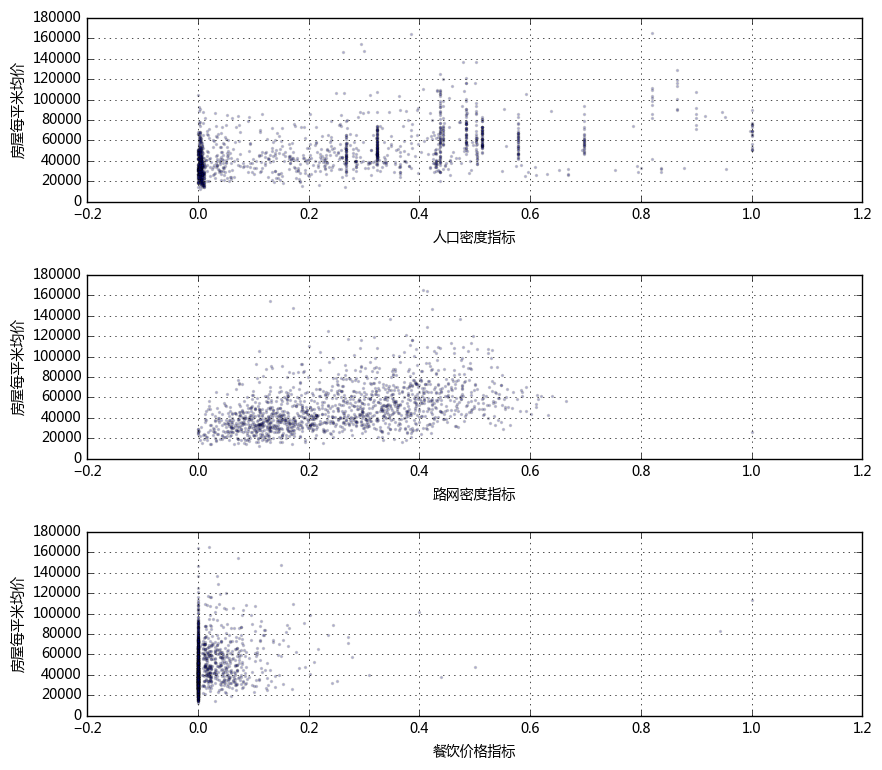

In [15]:
# 查看指标相关性

fig = plt.figure(figsize = (10,9))
plt.subplots_adjust(hspace=0.4)
# 设置绘图空间

ax1 = fig.add_subplot(3,1,1)
ax1.scatter(data_q3_test['人口密度指标'], data_q3_test['sell_area_'],s = 2,alpha = 0.2)
plt.xlabel('人口密度指标')
plt.ylabel('房屋每平米均价')
plt.grid()
# 散点图1 → 人口密度指标 - 房屋每平米均价

ax2 = fig.add_subplot(3,1,2)
ax2.scatter(data_q3_test['路网密度指标'], data_q3_test['sell_area_'],s = 2,alpha = 0.2)
plt.xlabel('路网密度指标')
plt.ylabel('房屋每平米均价')
plt.grid()
# 散点图2 → 路网密度指标 - 房屋每平米均价

ax3 = fig.add_subplot(3,1,3)
ax3.scatter(data_q3_test['餐饮价格指标'], data_q3_test['sell_area_'],s = 2,alpha = 0.2)
plt.xlabel('餐饮价格指标')
plt.ylabel('房屋每平米均价')
plt.grid()
# 散点图3 → 餐饮价格指标 - 房屋每平米均价

人口密度指标        0.501409
路网密度指标        0.449736
餐饮价格指标        0.186010
sell_area_    1.000000
离市中心距离       -0.734447
Name: sell_area_, dtype: float64

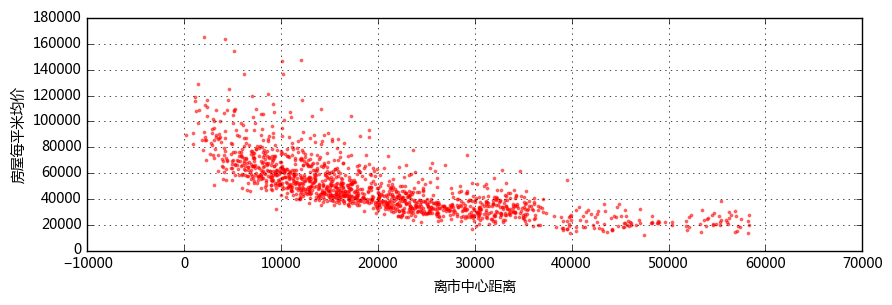

In [16]:
# 查看“房屋每平米均价”与离市中心距离的关系

fig = plt.figure(figsize = (10,3))

data_q3_test2 = data_q3_test.sort_values('离市中心距离')
plt.scatter(data_q3_test2['离市中心距离'], data_q3_test2['sell_area_'],color = 'red',s = 3,alpha = 0.5)
plt.xlabel('离市中心距离')
plt.ylabel('房屋每平米均价')
plt.grid()
# 散点图4 → 离市中心距离 - 房屋每平米均价

data_q3_test.corr().loc['sell_area_']
# 查看指标之间相关系数

# 结论
# ① 在上海全市层面，“离市中心距离”与“房屋每平米均价”相关性最强
# ② “人口密度”及“路网密度”和“房屋每平米均价”为中等相关
# ③ “餐饮价格”与“房屋每平米均价”为弱相关
# ④ “房屋每平米均价”数据的离散程度却和空间距离有关 → “房屋每平米均价”越靠近市中心越离散，越远离市中心则越收敛

In [ ]:
'''
4、按照离市中心距离每10km，分别再次判断人口密度、路网密度、餐饮价格和“房屋每平米均价”的相关程度
要求：
① 按照空间距离分别迭代计算三指标和“房屋每平米均价”的关系
② 绘制折线图查看：随着市中心距离增加，不同指标相关系系数变化情况
   *** 建议用bokeh制图
提示：
① 用for循环迭代空间距离，然后筛选数据并计算相关性
② bokeh可以通过多次调用figure.line()来绘制多条折线图

'''

In [17]:
# 按照空间距离分别迭代计算三指标和“房屋每平米均价”的关系

dis = []                # 距离空列表
rkmd_pearson = []       # 人口密度相关性系数空列表
lwmd_pearson = []       # 路网密度相关性系数空列表
cyjg_pearson = []       # 餐饮价格相关性系数空列表
zxjl_pearson = []       # 中心距离相关性系数空列表

for distance in range(10000,70000,10000):
    datai = data_q3_test[data_q3_test['离市中心距离'] <= distance]
    r_value = datai.corr().loc['sell_area_']
    # 筛选数据并计算相关系数
    dis.append(distance)
    rkmd_pearson.append(r_value.loc['人口密度指标'])
    lwmd_pearson.append(r_value.loc['路网密度指标'])
    cyjg_pearson.append(r_value.loc['餐饮价格指标'])
    zxjl_pearson.append(r_value.loc['离市中心距离'])
    # 添加列表值
    print('离市中心距离小于等于%i米：' % distance)
    print('数据量为%i条' % len(datai))
    print('人口密度与房屋每平米均价的相关系数为：%.3f' % r_value.loc['人口密度指标'])
    print('路网密度与房屋每平米均价的相关系数为：%.3f' % r_value.loc['路网密度指标'])
    print('餐饮价格与房屋每平米均价的相关系数为：%.3f' % r_value.loc['餐饮价格指标'])
    print('离市中心距离与房屋每平米均价的相关系数为：%.3f' % r_value.loc['离市中心距离'])
    print('-------\n')

离市中心距离小于等于10000米：
数据量为294条
人口密度与房屋每平米均价的相关系数为：0.069
路网密度与房屋每平米均价的相关系数为：-0.091
餐饮价格与房屋每平米均价的相关系数为：0.125
离市中心距离与房屋每平米均价的相关系数为：-0.493
-------

离市中心距离小于等于20000米：
数据量为795条
人口密度与房屋每平米均价的相关系数为：0.368
路网密度与房屋每平米均价的相关系数为：0.193
餐饮价格与房屋每平米均价的相关系数为：0.163
离市中心距离与房屋每平米均价的相关系数为：-0.594
-------

离市中心距离小于等于30000米：
数据量为1133条
人口密度与房屋每平米均价的相关系数为：0.493
路网密度与房屋每平米均价的相关系数为：0.377
餐饮价格与房屋每平米均价的相关系数为：0.166
离市中心距离与房屋每平米均价的相关系数为：-0.713
-------

离市中心距离小于等于40000米：
数据量为1328条
人口密度与房屋每平米均价的相关系数为：0.461
路网密度与房屋每平米均价的相关系数为：0.413
餐饮价格与房屋每平米均价的相关系数为：0.174
离市中心距离与房屋每平米均价的相关系数为：-0.731
-------

离市中心距离小于等于50000米：
数据量为1389条
人口密度与房屋每平米均价的相关系数为：0.489
路网密度与房屋每平米均价的相关系数为：0.441
餐饮价格与房屋每平米均价的相关系数为：0.185
离市中心距离与房屋每平米均价的相关系数为：-0.742
-------

离市中心距离小于等于60000米：
数据量为1431条
人口密度与房屋每平米均价的相关系数为：0.501
路网密度与房屋每平米均价的相关系数为：0.450
餐饮价格与房屋每平米均价的相关系数为：0.186
离市中心距离与房屋每平米均价的相关系数为：-0.734
-------



In [19]:
# 绘制折线图查看：随着市中心距离增加，不同指标相关性系数变化情况

from bokeh.models import HoverTool

df_r = pd.DataFrame({'rkmd_pearson':rkmd_pearson,
                    'lwmd_pearson':lwmd_pearson,
                    'cyjg_pearson':cyjg_pearson,
                    'zxjl_pearson':zxjl_pearson},
                   index = dis)
source = ColumnDataSource(data=df_r)
# 创建数据

hover = HoverTool(tooltips=[("离市中心距离", "@index"),
                           ("人口密度相关系数", "@rkmd_pearson"),
                           ("道路密度相关系数", "@lwmd_pearson"),
                           ("餐饮价格相关系数", "@cyjg_pearson"),
                           ("中心距离相关系数", "@zxjl_pearson"),])  
# 设置标签显示内容
p = figure(plot_width=900, plot_height=350, title="随着市中心距离增加，不同指标相关性系数变化情况",
          tools=[hover,'box_select,reset,xwheel_zoom,pan,crosshair'])
# 构建绘图空间
p.line(x='index',y='rkmd_pearson',source = source,line_alpha = 0.8, line_color = 'green',line_dash = [15,4],legend="人口密度相关系数") 
p.circle(x='index',y='rkmd_pearson',source = source, size = 8,color = 'green',alpha = 0.8,legend="人口密度相关系数")
# 绘制折线图1
p.line(x='index',y='lwmd_pearson',source = source,line_alpha = 0.8, line_color = 'blue',line_dash = [15,4],legend="道路密度相关系数") 
p.circle(x='index',y='lwmd_pearson',source = source, size = 8,color = 'blue',alpha = 0.8,legend="道路密度相关系数")
# 绘制折线图2
p.line(x='index',y='cyjg_pearson',source = source,line_alpha = 0.8, line_color = 'black',line_dash = [15,4],legend="餐饮价格相关系数") 
p.circle(x='index',y='cyjg_pearson',source = source, size = 8,color = 'black',alpha = 0.8,legend="餐饮价格相关系数")
# 绘制折线图3
p.line(x='index',y='zxjl_pearson',source = source,line_alpha = 0.8, line_color = 'red',line_dash = [15,4],legend="中心距离相关系数") 
p.circle(x='index',y='zxjl_pearson',source = source, size = 8,color = 'red',alpha = 0.8,legend="中心距离相关系数")
# 绘制折线图4
p.legend.location = "center_right"
show(p)
# 绘制折线图

df_r

# 结论
# ① “人口密度”、“道路密度”、“离市中心距离”和“房屋均价”有着明显的相关性，而“餐饮价格”和“房屋均价”相关性较弱
# ② 随着离市中心的距离越远，指标的相关性在数据上体现更明显，而这个分界线大概在20-30km处，这正是上海中心城区和郊区的分界
#    → 上海房价市场的“中心城区-郊区”分化特征
# ③ 中心城区的房产市场对指标因素的影响更加敏锐，而郊区则更迟钝 → 越靠近市中心，影响因素越复杂

,cyjg_pearson,lwmd_pearson,rkmd_pearson,zxjl_pearson
10000,0.124991,-0.091326,0.069072,-0.493018
20000,0.162558,0.193454,0.367922,-0.593922
30000,0.165939,0.377449,0.493357,-0.712952
40000,0.173529,0.412577,0.461441,-0.730727
50000,0.185447,0.441350,0.488776,-0.742145
60000,0.186010,0.449736,0.501409,-0.734447
